# Project: Quantifying the Performance of the Binomial Lattice Model

## Learning Objectives
In this project students will test the effectivness of the binomial lattice model as a predictive approach for short-term projection of equity share price. 

* __Objective__: Quantify the binomial lattice model prediction rate by comparing historical data for different periods and different firms with lattice model predictions.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our example problem.

### Packages
Fill me in.

### Types
Fill me in.

### Functions
Fill me in.

In [1]:
include("Include.jl");

  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-132/module-1`


## Prerequisite: Load the Binomial Lattice Model Parameters and Historical Dataset
Fill me in

In [2]:
parameters = loadmodelparametersfile();

Fill me in

In [3]:
years = ["Year-1", "Year-2", "Year-3", "Year-4", "Year-5"];
number_of_firms = nrow(parameters);
dataset = Dict{Int64,DataFrame}();
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    for year ∈ years
        tmp_data = loaddatafile(firm=firm_index, year=year);
        
        if (haskey(dataset,firm_index) == false)
            dataset[firm_index] = tmp_data;
        else
            append!(dataset[firm_index], tmp_data)
        end
    end
end

### Clean the dataset: missing data
Not all the firms in the `dataset` have the maximum number of trading days, i.e., some firms are missing information for various reasons; perhaps they were acquired, merged, or were delisted, etc. We will exclude these firms from the `dataset`.

#### Implementation
First, we specify the `max_number_of_records` variable, which holds the number of trading records we expect for each firm, in this case, `1256`. Then, we iterate through all the firms in the `dataset` using a `for` loop. We remove those firms from the `dataset` whose row count (calculated by calling the `nrow(...)` function) is not equal to the `max_number_of_records`; a firm is removed from the `dataset` using the [delete! function](https://docs.julialang.org/en/v1/base/collections/#Base.delete!):

In [4]:
max_number_of_records = 1256
for i ∈ 1:number_of_firms
    firm_index = parameters[i,:firm];
    data = dataset[firm_index];
    
    if (nrow(data) != max_number_of_records)
        delete!(dataset, firm_index);
    end
end

Finally, now that we have removed firms with missing data from the `dataset`, we populate the variable `list_of_firm_ids` which holds a sorted array of `firm_id` values, and determine the number of firms in the `dataset` using the `length(...)` function, which we store in the `number_of_firms` variable:

In [5]:
list_of_firm_ids = keys(dataset) |> collect |> sort;
number_of_firms = length(list_of_firm_ids);

## Objective: Quantifying the Binomial Lattice Model Prediction Rate
This task aims to determine the prediction accuracy of the Binomial Lattice Model. To accomplish this, we will divide time into contiguous segments $\mathcal{I}_{k}\in\mathcal{I}$ of length `T` days. At the start of each interval $\mathcal{I}_{k}$, we will construct and populate a binomial lattice model using the `build(…)` and `populate(…)` functions. Then, we will compare the actual price of a firm denoted by $S_{j}$ at time $j$ with the simulated price during each time segment: 

* If the simulated price falls between a lower bound $L_{j}$ and an upper bound $U_{j}$ for all $j\in\mathcal{I}_{k}$, the simulation is considered a `success`.
* However, if the actual price violates either the lower or upper bound at any point in time, the simulation is deemed a `failure`.

Specify the length of each time interval in the `T::Int64` variable. Let's set `T = 21` days:

In [6]:
T = 21;

We then partition time into intervals $\mathcal{I}\in\mathcal{I}$. We define the variable `date_range_array` which holds time intervals, and populate this array using a `for` loop. During each pass of the loop, we calculate the range `range(i,stop=(i+T-1),step=1)` and add this range to the `date_range_array` using the `push!(...)` function. Finally, we compute the number of intervals by calling the `length(...)` function on the `date_range_array` , we store the number of intervals in the variable `number_of_date_ranges`:

In [7]:
date_range_array = Array{StepRange{Int64, Int64},1}();
start_index = 1;
for i ∈ 1:T:(max_number_of_records - T)
    range(i,stop=(i+T-1),step=1) |> (x-> push!(date_range_array,x))
end
number_of_date_ranges = length(date_range_array);

### Simulation
The (hidden) simulation code block produces two data structures: 
* The `successful_simulation_dict = Dict{Int64, Array{Array{Float64,2},1}}()` data structure holds simulation results that have `passed` the bounds test described above. The `keys` of the `successful_simulation_dict` correspond to the `firm_id`, while the values hold an array of simulation arrays which are encoded as an `Array{Float64,2}`, i.e., a matrix of successful simulation results.
* The `failed_simulation_dict = Dict{Int64, Array{Array{Float64,2},1}}()` data structure holds simulation results that have `failed` the bounds test described above. The `keys` of the `failed_simulation_dict` correspond to the `firm_id`, while the values hold an array of simulation arrays, which are encoded as an `Array{Float64,2}`, i.e., a matrix of failed simulation results.

In [8]:
z_score = [1.0,1.96,2.576]
successful_simulation_dict = Dict{Int64, Array{Array{Float64,2}, 1}}()
failed_simulation_dict = Dict{Int64, Array{Array{Float64,2}, 1}}()
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    # parameters -
    ū = parameters[parameters.firm .== firm_id, :up] |> first;
    d̄ = parameters[parameters.firm .== firm_id, :down] |> first;
    p̄ = parameters[parameters.firm .== firm_id, :probability] |> first;
    
    # data for this firm
    data = dataset[firm_id];
    
    # process each data range, for firm_id
    for j ∈ 1:number_of_date_ranges
        date_range = date_range_array[j]
        start_index = first(date_range)
        
        # set the starting price
        Sₒ = data[start_index, :volume_weighted_average_price];
        
        # build the model, populate with price estimates 
        model = build(MyBinomialEquityPriceTree, (
            u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ, T));
        
        
        simulation_data_array = Array{Float64,2}(undef, T, 10);
        for k ∈ 0:(T-1)
            simulation_data_array[k+1,1] = k+start_index
            simulation_data_array[k+1,2] = data[start_index+k,:volume_weighted_average_price]
            simulation_data_array[k+1,3] = 𝔼(model,level=k);
            simulation_data_array[k+1,4] = 𝕍(model,level=k) |> sqrt;

            # compute an upper and lower bound -
            simulation_data_array[k+1,5] = simulation_data_array[k+1,3] .- z_score[1]*simulation_data_array[k+1,4]
            simulation_data_array[k+1,6] = simulation_data_array[k+1,3] .+ z_score[1]*simulation_data_array[k+1,4]
            
            # compute an upper and lower bound -
            simulation_data_array[k+1,7] = simulation_data_array[k+1,3] .- z_score[2]*simulation_data_array[k+1,4]
            simulation_data_array[k+1,8] = simulation_data_array[k+1,3] .+ z_score[2]*simulation_data_array[k+1,4]
            
            # compute an upper and lower bound -
            simulation_data_array[k+1,9] = simulation_data_array[k+1,3] .-  z_score[3]*simulation_data_array[k+1,4]
            simulation_data_array[k+1,10] = simulation_data_array[k+1,3] .+ z_score[3]*simulation_data_array[k+1,4]
        end
        
        # was this a good prediction?
        L = simulation_data_array[:,9]
        U = simulation_data_array[:,10]
   
        # check the bounds: if below L, or above U then simulation failed
        prediction_ok = true;
        for k ∈ 1:T
            if (data[start_index+k-1,:volume_weighted_average_price] < L[k]) || (data[start_index+k-1,:volume_weighted_average_price] > U[k])
                prediction_ok = false;
                break;
            end
        end
        
        key = firm_id
        if (prediction_ok == true)
            
            if (haskey(successful_simulation_dict, key) == false)
                tmp = Array{Array{Float64,2},1}();
                push!(tmp, simulation_data_array);
                successful_simulation_dict[key] = tmp;
            else
                push!(successful_simulation_dict[key], simulation_data_array);
            end
        else
            
            if (haskey(failed_simulation_dict, key) == false)
                tmp = Array{Array{Float64,2},1}();
                push!(tmp, simulation_data_array)
                failed_simulation_dict[key] = tmp;
            else
                push!(failed_simulation_dict[key], simulation_data_array);
            end
        end
    end
end

#### Analysis of an example failed simulations
Fill me in.

In [39]:
firm_index = 232;
failed_simulation_index = 2;

##### Visualize

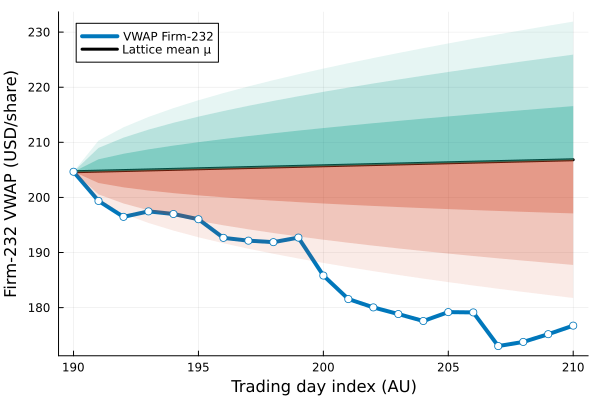

In [46]:
example_failed_sim = failed_simulation_dict[firm_index][failed_simulation_index]
L68 = example_failed_sim[:,5]
U68 = example_failed_sim[:,6]
L95 = example_failed_sim[:,7]
U95 = example_failed_sim[:,8]
L99 = example_failed_sim[:,9]
U99 = example_failed_sim[:,10]

plot(example_failed_sim[:,1],example_failed_sim[:,2], c=colors[2], lw=4,label="VWAP Firm-$(firm_index)", legend=:topleft)
plot!(example_failed_sim[:,1],example_failed_sim[:,3], c=:black, lw=3, label="Lattice mean μ")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L99, alpha=0.1, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U99, alpha=0.1, c=colors[6], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L95, alpha=0.2, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U95, alpha=0.2, c=colors[6], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=L68, alpha=0.30, c=colors[5], label="")
plot!(example_failed_sim[:,1],example_failed_sim[:,3], fillrange=U68, alpha=0.30, c=colors[6], label="")
scatter!(example_failed_sim[:,1] ,example_failed_sim[:,2], msc=colors[2], mc=:white, label="")
xlabel!("Trading day index (AU)",fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)",fontsize=18)

### Compute the probability of success $p_{+}$ and failure $p_{-}$ for each firm
Fill me in

In [24]:
probability_dictionary = Dict{Int64, Tuple{Float64,Float64}}()
for i ∈ 1:number_of_firms
    firm_id = list_of_firm_ids[i];
    
    N₊ = successful_simulation_dict[firm_id] |> length    
    p₊ = N₊/number_of_date_ranges;
   
    probability_dictionary[firm_id] = (p₊,1-p₊)
end

In [43]:
probability_dictionary[232]

(0.6949152542372882, 0.30508474576271183)

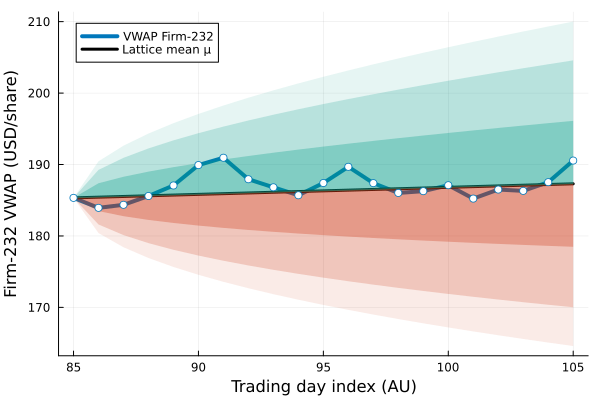

In [51]:
example_success_sim = successful_simulation_dict[firm_index][4]
L68 = example_success_sim[:,5]
U68 = example_success_sim[:,6]
L95 = example_success_sim[:,7]
U95 = example_success_sim[:,8]
L99 = example_success_sim[:,9]
U99 = example_success_sim[:,10]

plot(example_success_sim[:,1],example_success_sim[:,2], c=colors[2], lw=4,label="VWAP Firm-$(firm_index)", legend=:topleft)
plot!(example_success_sim[:,1],example_success_sim[:,3], c=:black, lw=3, label="Lattice mean μ")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L99, alpha=0.1, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U99, alpha=0.1, c=colors[6], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L95, alpha=0.2, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U95, alpha=0.2, c=colors[6], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=L68, alpha=0.30, c=colors[5], label="")
plot!(example_success_sim[:,1],example_success_sim[:,3], fillrange=U68, alpha=0.30, c=colors[6], label="")
scatter!(example_success_sim[:,1] ,example_success_sim[:,2], msc=colors[2], mc=:white, label="")
xlabel!("Trading day index (AU)",fontsize=18)
ylabel!("Firm-$(firm_index) VWAP (USD/share)",fontsize=18)